In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 cleaned_data		       'General presentation.gslides'
 fil_1yr_66cols_pos_mixed.csv   notebooks


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Javiera_Research')

In [ ]:
!ls

 cleaned_data		       'General presentation.gslides'
 fil_1yr_66cols_pos_mixed.csv   notebooks


# Imports

In [ ]:
!pip install pyclustering

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 20.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339934 sha256=c83b227b501c2abaf5fc3d89277518601d0dd20196eca4e9cf72b7124caa5f44
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [ ]:
!pip install gower

  Created wheel for gower: filename=gower-0.0.5-cp37-none-any.whl size=4232 sha256=53310446de1e8459369d3bd894aa222ceb8e5dd5e9099a5abc5fe66140ef9e21
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.samples.definitions import FCPS_SAMPLES

import gower

# load filtered data

In [ ]:
# df_1yr = pd.read_csv('cleaned_data/ukb43673_74cols_1yr.csv')
df = pd.read_csv('fil_1yr_66cols_pos_mixed.csv')
df

,53-2.0,1920-2.0,1930-2.0,1940-2.0,1950-2.0,1960-2.0,1970-2.0,1980-2.0,1990-2.0,2000-2.0,2010-2.0,2020-2.0,2030-2.0,2050-2.0,2060-2.0,2070-2.0,2080-2.0,20400-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21024-0.0,21033-0.0,21034-0.0,21035-0.0,21038-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,21064-0.0,21065-0.0,21068-0.0,eid,31-0.0,21025-0.0,time_lapse1,time_lapse2
0,2016-06-07,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2016-08-17,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,49.0,2017-04-27,0.0,-502.0,-501.0,0.0,0.0,7.0,0.0,4.0,7.0,2.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-602.0,-600.0,-600.0,-601.0,-601.0,0.0,0.0,0.0,1020090.0,1.0,1.0,-71 days,-324 days
1,2017-05-11,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2016-08-24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,63.0,2017-04-13,0.0,-501.0,-501.0,0.0,0.0,1.0,0.0,3.0,6.0,2.0,-602.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,0.0,0.0,0.0,1020676.0,1.0,0.0,260 days,28 days
2,2016-09-19,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2016-08-24,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,2.0,72.0,2017-04-28,0.0,-500.0,-501.0,0.0,0.0,2.0,0.0,2.0,7.0,1.0,-602.0,-601.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-600.0,-600.0,-601.0,-601.0,0.0,0.0,0.0,1020687.0,1.0,0.0,26 days,-221 days
3,2016-09-15,0.0,0.0,1.0,1.0,0.0,-1.0,1.0,0.0,1.0,0.0,0.0,-1.0,1.0,1.0,1.0,1.0,2016-08-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,61.0,2017-08-30,0.0,-502.0,-500.0,0.0,1.0,5.0,0.0,3.0,4.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-602.0,-600.0,-600.0,-601.0,-601.0,0.0,0.0,0.0,1020869.0,0.0,0.0,27 days,-349 days
4,2017-09-27,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,4.0,2016-11-17,1.0,1.0,2.0,2.0,1.0,3.0,3.0,1.0,1.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,68.0,2017-05-01,0.0,-501.0,-501.0,1.0,0.0,2.0,0.0,2.0,5.0,1.0,-601.0,-602.0,-601.0,-600.0,-602.0,-600.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,0.0,1.0,0.0,1022053.0,0.0,1.0,314 days,149 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2016-07-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2016-08-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,2017-05-04,0.0,-500.0,-500.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,0.0,0.0,0.0,6021110.0,1.0,1.0,-25 days,-283 days
6152,2016-12-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2016-12-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-04-28,0.0,-500.0,-500.0,0.0,0.0,2.0,0.0,2.0,7.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-602.0,-600.0,-600.0,-601.0,0.0,0.0,0.0,6022430.0,1.0,0.0,6 days,-131 days
6153,2017-09-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2016-09-22,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-05-20,0.0,-501.0,-501.0,1.0,0.0,2.0,5.0,2.0,3.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-600.0,-600.0,1.0,0.0,0.0,6022902.0,1.0,5.0,352 days,112 days
6154,2017-06-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,2.0,2016-08-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,57.0,2017-04-26,1.0,-500.0,-501.0,1.0,1.0,10.0,8.0,2.0,7.0,1.0,-601.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,1.0,0.0,0.0,60

# Encode categorical columns

In [ ]:
df.dtypes[~(df.dtypes=='float64')]

53-2.0         object
20400-0.0      object
21023-0.0      object
time_lapse1    object
time_lapse2    object
dtype: object

In [ ]:
time_cols = list(df.dtypes[~(df.dtypes=='float64')].index)

In [ ]:
# all of those columns are date columns
# date of attending center
# date of mental health questionaire
# date of digestive questionaire
# and the 2 time lapses
# we should not use these for cluster
df_clus = df.drop(time_cols, axis='columns')

In [ ]:
df_clus.set_index('eid', drop=True, inplace=True)
  # set eid as our index because it is not really a feature

In [ ]:
# load Andrews csv to get a list of the data types for each column
# categorical or integer
meta_df = pd.read_csv('cleaned_data/ukb_response_impute_ref_stats_group_ds3.csv')
meta_df_cols = meta_df[['UDI','Type']]

In [ ]:
# because we mannually added two 2 columns to this list, add them to the df
i = len(meta_df_cols)
meta_df_cols.loc[i] = ['21025-0.0', 'Categorical (single)']
meta_df_cols.loc[i+1] = ['31-0.0', 'Categorical (single)']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
meta_df_cols = meta_df_cols[meta_df_cols['UDI'].isin(df_clus.columns)]
  # keep the meta for columns that are actually in our dataframe

In [ ]:
meta_df_cols[meta_df_cols['Type'] == 'Integer']

,UDI,Type
44,21003-2.0,Integer
53,21042-0.0,Integer
54,21043-0.0,Integer
55,21044-0.0,Integer


In [ ]:
int_cols = list(meta_df_cols[meta_df_cols['Type'] == 'Integer']['UDI'])
  # these are the only numerical columns
  # the rest of the columns are either categorical or are datetime objects
int_cols

['21003-2.0', '21042-0.0', '21043-0.0', '21044-0.0']

In [ ]:
cat_cols = list(df_clus.columns[~df_clus.columns.isin(int_cols)])
len(cat_cols)
  # 66 (- 5 - 1 )- 4 = 56

56

In [ ]:
df_clus['1920-2.0'].unique()

array([ 0.,  1., -1., -3.])

In [ ]:
df_clus_encoded = df_clus.copy()
oe = preprocessing.OrdinalEncoder()
df_clus_encoded[cat_cols] = oe.fit_transform(df_clus[cat_cols])

In [ ]:
df_clus_encoded['1920-2.0'].unique()

array([2., 3., 1., 0.])

In [ ]:
df_clus.shape == df_clus_encoded.shape

True

In [ ]:
# later, transform back with 
# df_clus_encoded[cat_cols] = oe.inverse_transform(df_clus[cat_cols])

In [ ]:
int_cols

['21003-2.0', '21042-0.0', '21043-0.0', '21044-0.0']

In [ ]:
for i in range(len(int_cols)):
    print(list(df_clus_encoded.columns).index(int_cols[i]))
# these indices willbe used to plot pairwise clsuters later

32
40
41
42


In [ ]:
list(df_clus_encoded.columns)[32]

'21003-2.0'

# k-medoids example

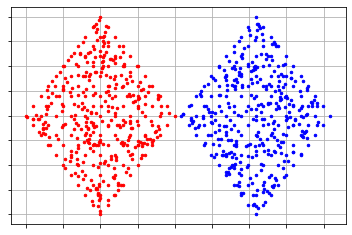

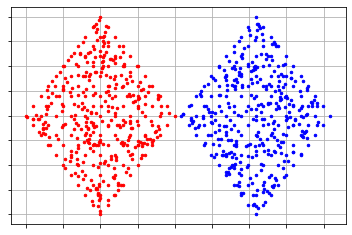

In [ ]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
# Set random initial medoids.
initial_medoids = [1, 500]
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(sample, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
# print(clusters)
# Display clusters.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.show()

# k-medois with euclidean distance on our data

In [ ]:
my_scaler = MinMaxScaler()  
my_scaler.fit(df_clus_encoded)  

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# tranform returns a numpy array which is perfect to pass into the kmedoids function
df_clus_encoded_scaled = my_scaler.transform(df_clus_encoded)

In [ ]:
# Set random initial medoids, randomly choose 4 indices from all available indices
initial_medoids = np.random.randint(0, df_clus_encoded_scaled.shape[0],5)
initial_medoids

array([5358,  252, 3829,  272,  261])

In [ ]:
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(df_clus_encoded_scaled.tolist(), initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()

In [ ]:
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
len(clusters)
for i in clusters:
  print(i)

[3, 4, 11, 15, 23, 26, 28, 31, 42, 43, 44, 46, 56, 58, 59, 78, 83, 90, 91, 92, 107, 114, 116, 119, 128, 136, 149, 159, 174, 181, 186, 191, 193, 194, 204, 209, 212, 213, 219, 229, 232, 244, 247, 251, 265, 269, 280, 284, 290, 293, 298, 303, 308, 309, 327, 333, 343, 368, 387, 389, 394, 402, 404, 408, 411, 430, 432, 440, 442, 449, 458, 461, 462, 474, 480, 484, 494, 500, 507, 516, 517, 524, 526, 532, 536, 539, 540, 547, 551, 553, 555, 569, 571, 573, 579, 585, 586, 589, 595, 610, 615, 617, 624, 627, 631, 633, 640, 641, 645, 646, 648, 661, 662, 666, 667, 668, 672, 682, 684, 685, 687, 690, 699, 705, 722, 728, 732, 744, 749, 750, 757, 772, 774, 776, 779, 792, 795, 798, 799, 805, 807, 809, 815, 816, 820, 825, 826, 830, 832, 834, 837, 838, 853, 854, 858, 859, 862, 876, 879, 880, 882, 892, 895, 900, 902, 904, 907, 908, 926, 927, 928, 932, 934, 941, 942, 949, 953, 959, 963, 968, 971, 973, 985, 988, 991, 993, 998, 1019, 1029, 1036, 1044, 1047, 1052, 1053, 1057, 1067, 1068, 1070, 1082, 1083, 1087, 10

In [ ]:
medoids = kmedoids_instance.get_medoids()
medoids

[579, 3082, 1050, 3407, 356]

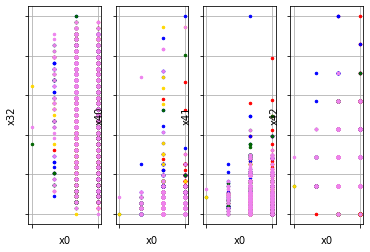

In [ ]:
# Display clusters.
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, df_clus_encoded_scaled.tolist())
  # only works with a list of lists, does NOT work with np array
visualizer.show(pair_filter=[[0, 32], [0, 40],[0,41],[0,42]])
# visualizer.show(max_row_size=3)

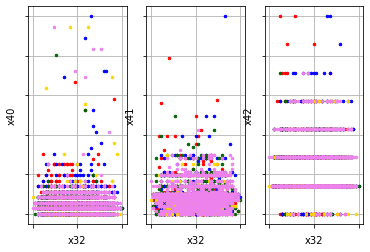

In [ ]:
visualizer.show(pair_filter=[[32, 40],[32,41],[32,42]])

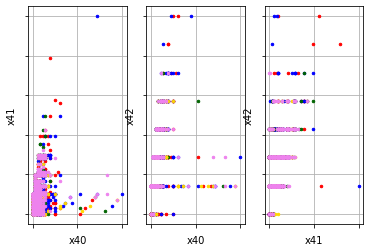

In [ ]:
visualizer.show(pair_filter=[[40,41],[40,42],[41,42]])

# k-medoids with gower on our data

## setup gower distance

ower Distance is a distance measure that can be used to calculate distance between two entity whose attribute has a mixed of categorical and numerical values, which fits our use case. 

View how it works [here](https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553).

View API [here](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/).

In [ ]:
euclid_metric = distance_metric(type_metric.EUCLIDEAN)
euclid_metric([3, 0], [0,4])

5.0

In [ ]:
# User may define its own function for distance calculation.
# In this case input is two points.

In [ ]:
gower.gower_matrix(df_clus)

array([[ 0.        , -0.01309858,  0.00095213, ...,  0.00088414,
         0.0266407 ,  0.04536565],
       [-0.01309858,  0.        ,  0.01461027, ...,  0.00769085,
         0.01288683,  0.04207953],
       [ 0.00095213,  0.01461027,  0.        , ..., -0.00961742,
         0.02528162,  0.03267866],
       ...,
       [ 0.00088414,  0.00769085, -0.00961742, ...,  0.        ,
         0.00764198,  0.04965576],
       [ 0.0266407 ,  0.01288683,  0.02528162, ...,  0.00764198,
         0.        ,  0.02759229],
       [ 0.04536565,  0.04207953,  0.03267866, ...,  0.04965576,
         0.02759229,  0.        ]], dtype=float32)

In [ ]:
df_clus_encoded.iloc[[0],:]

,1920-2.0,1930-2.0,1940-2.0,1950-2.0,1960-2.0,1970-2.0,1980-2.0,1990-2.0,2000-2.0,2010-2.0,2020-2.0,2030-2.0,2050-2.0,2060-2.0,2070-2.0,2080-2.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21024-0.0,21033-0.0,21034-0.0,21035-0.0,21038-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,21064-0.0,21065-0.0,21068-0.0,31-0.0,21025-0.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1020090.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,49.0,2.0,3.0,4.0,1.0,1.0,8.0,1.0,4.0,7.0,2.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0


In [ ]:
col_is_cat = df_clus_encoded.columns.isin(cat_cols)

In [ ]:
gower.gower_matrix(df_clus_encoded.iloc[[0]],df_clus_encoded.iloc[[1]])
  # we can just select 2 rows and compute their gower distance, BUT ONLY UNDER THE RESTRICTION
  # that they are both dataframes, with columns
  # else the code cannot process correctly

array([[0.33333334]], dtype=float32)

In [ ]:
# we should specify which columns are categorical, because it might not infer correctly by itself

gower.gower_matrix(df_clus_encoded.iloc[[0]],df_clus_encoded.iloc[[1]],
                   cat_features=col_is_cat)
  # we can just select 2 rows and compute their gower distance, BUT ONLY UNDER THE RESTRICTION
  # that they are both dataframes, with columns
  # else the code cannot process correctly

array([[0.33333334]], dtype=float32)

In [ ]:
euclid_metric(df_clus_encoded.iloc[0],df_clus_encoded.iloc[1])
# we can see it is definitely different then Euclidean distance

16.401219466856727

In [ ]:
# user_defined can only be defined on 2 arguments!
def gower_dis(point1, point2):
    result = gower.gower_matrix(point1,
                                point2,
                                cat_features=col_is_cat)
    return result

gower_metric = distance_metric(type_metric.USER_DEFINED, func=gower_dis)
gower_metric(df_clus_encoded.iloc[[0]], df_clus_encoded.iloc[[1]])

array([[0.33333334]], dtype=float32)

In [ ]:
# now the problem becomes, when kmedoids select 2 points to feed into this metric, are they treated as 1-row dfs?
# will their column information be maintained for our gower_matrix function?

In [ ]:
kmedoids_instance = kmedoids(df_clus_encoded, initial_medoids)
kmedoids_instance.process()
# the kmedoids function cannot even takein dataframes!
# we must convert our dataframes into numpy arrays first
# then in the distance function, convert each row into a dataframe with column names, then the gower_matrix function would work
# but other problem arises, see notes in 4/13 meeting

KeyError: ignored

In [ ]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(df_clus_encoded)